In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def collect_x(df, x_cols):
    mat = []
    mat.append(df[x_cols].values)
    return np.asarray(mat)

In [3]:
df = pd.read_csv('./gambling-2017.csv')
lgas = df['LGA Name'][0:-3]
df = df[df['LGA Name'].isin(lgas)]
df['Region'] = df['Region'].apply(lambda x: 1 if "M" in x else 0)
df['DIS Score '] = df['DIS Score '].apply(lambda x: float(x))
df['per Venue 2017'] = df['per Venue 2017'].apply(lambda x: np.nan if '-' in x else float(x.replace(',', '')))
df['per Adult 2017'] = df['per Adult 2017'].apply(lambda x: np.nan if '-' in x else float(x))
df['Unemployment rate '] = df['Unemployment rate '].apply(lambda x: np.nan if '-' in x else float(x.replace('%', '')))
df = df.dropna()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 0 to 69
Data columns (total 19 columns):
LGA Name                 70 non-null object
LGA                      70 non-null object
Region                   70 non-null int64
Net Expenditure ($)      70 non-null object
DIS Score                70 non-null float64
DIS Rank State           70 non-null object
DIS RANK COUNTRY         70 non-null object
DIS RANK METRO           70 non-null object
ADVDIS Score             70 non-null object
ADVDIS Rank State        70 non-null object
ADVDIS RANK COUNTRY      70 non-null object
ADVDIS RANK METRO        70 non-null object
Population 2017          70 non-null object
per Venue 2017           70 non-null float64
per 1,000 Adults 2017    70 non-null object
per Adult 2017           70 non-null float64
Workforce                70 non-null object
Unemployed               70 non-null object
Unemployment rate        70 non-null float64
dtypes: float64(4), int64(1), object(14)
memory usage: 10.

,LGA Name,LGA,Region,Net Expenditure ($),DIS Score,DIS Rank State,DIS RANK COUNTRY,DIS RANK METRO,ADVDIS Score,ADVDIS Rank State,ADVDIS RANK COUNTRY,ADVDIS RANK METRO,Population 2017,per Venue 2017,"per 1,000 Adults 2017",per Adult 2017,Workforce,Unemployed,Unemployment rate
0,City of Whittlesea,M26,1,"106,994,642.75",988.60,38,-,5,983.36,44,-,4,"157,370",15737.0,4,679.89,"111,495","8,151",7.31
1,Shire of Nillumbik,M16,1,"8,298,522.61",1098.26,80,-,31,"1,099.03",78,-,26,"48,614",24307.0,2,170.70,"39,288","1,022",2.60
2,RURAL CITY OF ARARAT,C43,0,"4,921,777.36",950.51,11,9,-,938.42,11,9,-,"8,712",4356.0,10,564.94,"5,616",308,5.48
3,Shire of Northern Grampians,C14,0,"4,183,804.74",937.59,6,4,-,925.61,5,6,-,"9,131",4566.0,9,458.19,"5,742",290,5.05
4,Borough of Queenscliffe,C1,0,"1,282,462.14",1053.20,71,46,-,"1,047.25",69,47,-,"2,524",2524.0,12,508.09,"1,371",41,2.99


In [4]:
x= collect_x(df, ['DIS Score ', 'per Venue 2017', 'Region', 'per Adult 2017'])[0, :, :]
dfmin = df['Unemployment rate '].min()
dfmax = df['Unemployment rate '].max()
y = df['Unemployment rate '].values
y = y.reshape((len(y), 1))
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [5]:
no_epochs = 40000

In [6]:
X = tf.placeholder(tf.float32, shape=[None, x.shape[-1]])
Y = tf.placeholder(tf.float32, shape=[None, 1])
keep_prob = tf.placeholder(tf.float32)

In [7]:
sx = [] # Sampled x values
sy = [] # Sampled y values
real = [] # Real values
predicted = [] # Predicted values

# Leaky ReLu should be used to stop vanishing gradient problem
input_layer = tf.contrib.layers.fully_connected(X, 6, activation_fn=tf.nn.leaky_relu)
# This dropout layer is crucial to stop overfitting, since the data points are very small.
dropout_layer = tf.contrib.layers.dropout(input_layer, keep_prob=keep_prob)
hidden_layer = tf.contrib.layers.fully_connected(dropout_layer, 2, activation_fn=tf.nn.leaky_relu)
output_layer = tf.contrib.layers.fully_connected(dropout_layer, 1, activation_fn=tf.nn.leaky_relu)

loss = tf.reduce_sum(tf.abs(Y - output_layer))

#learning rate is set to a default of 0.001, this is fine, I would probably go lower but
# I want this to finish in a reasonable time.
train = tf.train.AdamOptimizer().minimize(loss)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for i in range(no_epochs):
        if i%100 == 0:
            # We are testing the accuracy so we need fully connected layers here.
            out = sess.run(output_layer, feed_dict={X: X_test, keep_prob: 1.0})
            correct = sess.run(tf.reduce_mean(tf.abs(out - y_test)))
            sx.append(i)
            sy.append(correct)
            print(i, correct)
            
        # Dropout of 0.5 is good to help stop over-fitting. 
        sess.run(train, feed_dict={X: X_train, Y: y_train, keep_prob: 0.5})
    
    # Let us compare how we went against the test set
    out = sess.run(output_layer, feed_dict={X: X_test, keep_prob: 1.0})
    for i in range(len(y_test)):
        real.append(y_test[i][0])
        predicted.append(out[i][0])
        print(out[i], y_test[i], y_test[i]-out[i])


0 9189.574375
100 3866.9415548706056
200 926.716547940175
300 112.85559364318847
400 195.77544958750408
500 278.57603406270346
600 358.6362357076009
700 338.6446820831299
800 272.1526722844442
900 202.04666184743246
1000 134.3776253000895
1100 74.04874061902363
1200 28.851531688570976
1300 21.299617082327604
1400 18.814095844998956
1500 18.600938109233976
1600 18.224532146297086
1700 18.132637855149806
1800 17.850479895190023
1900 17.68011619913081
2000 17.573320895917714
2100 17.73265110904972
2200 17.058804252048333
2300 16.76161953141292
2400 16.766438869933285
2500 16.222990696181853
2600 15.928249938587348
2700 15.73307048826168
2800 15.262330938614904
2900 14.955033761933445
3000 14.678320976148049
3100 13.979618242805202
3200 14.06584081288427
3300 13.631738582799832
3400 12.876919986853997
3500 12.391639935802667
3600 12.415113877058028
3700 11.947159152030943
3800 11.345670286118983
3900 10.698747203548749
4000 9.997607256770134
4100 10.004119112392265
4200 9.424725307325522
4

33700 1.3305392436186472
33800 1.313273119131724
33900 1.3757706952095032
34000 1.5036895147959388
34100 1.2814486249287924
34200 1.468579825957616
34300 1.3576397669315339
34400 1.2821475589275362
34500 1.2878444516658785
34600 1.421971407731374
34700 1.3995772075653077
34800 1.2435510182380678
34900 1.2308855577309927
35000 1.2962873848279317
35100 1.3966120751698812
35200 1.36300656914711
35300 1.4048273932933808
35400 1.3206487933794657
35500 1.2942241255442302
35600 1.2972723865509035
35700 1.397228307723999
35800 1.3648394020398458
35900 1.398323761622111
36000 1.2631167594591777
36100 1.2873819593588511
36200 1.3238795471191407
36300 1.365099437236786
36400 1.3435246817270914
36500 1.3397894970575968
36600 1.369703359603882
36700 1.2585138106346132
36800 1.354255087375641
36900 1.3198663862546285
37000 1.280421090523402
37100 1.3769418768088022
37200 1.2593736076354982
37300 1.3297190141677857
37400 1.2826030079523723
37500 1.2786221925417582
37600 1.3847924955685933
37700 1.304

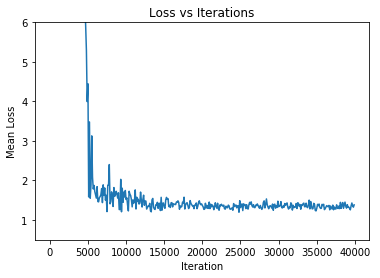

In [8]:
plt.plot(sx, sy)
plt.ylim((0.5, 6))
plt.xlabel("Iteration")
plt.ylabel('Mean Loss')
plt.title("Loss vs Iterations")
plt.savefig('loss_vs_iter.png', dpi=1080)
plt.show()

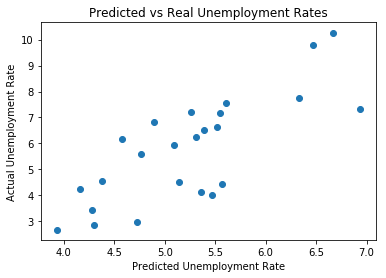

In [9]:
plt.scatter(predicted, real)
plt.xlabel("Predicted Unemployment Rate")
plt.ylabel("Actual Unemployment Rate")
plt.title("Predicted vs Real Unemployment Rates")
plt.savefig('predicted_vs_real_urate.png', dpi=1080)
plt.show()

In [10]:
pearsonr(predicted, real)

(0.7795278152268961, 7.131295825120321e-06)

In [11]:
predicted = np.asarray(predicted)
real = np.asarray(real)
np.mean(np.abs(predicted-real))

1.3558266433080037